In [1]:
# 경로/열/하이퍼파라미터
from pathlib import Path

DATA_DIR = Path(r"C:\Users\human\Desktop\강의자료\팀플1\archive")

columns = ["timestamp", "cut torque", "cut lag error", "cut position",
           "cut speed", "film position", "film speed", "film lag error"]

# 우선 cut 계열만 사용(필요 시 film 계열 추가 비교)
exclude_cols = ["timestamp",'cut position', "film position"]
keep_cols = [c for c in columns if c not in exclude_cols]
keep_cols


['cut torque', 'cut lag error', 'cut speed', 'film speed', 'film lag error']

In [2]:
import pandas as pd
import numpy as np
from glob import glob

def load_three(prefix="NewBlade"):
    files = sorted(glob(str(DATA_DIR / f"{prefix}00*.csv")))[:3]
    dfs = [pd.read_csv(f) for f in files]
    for i in range(len(dfs)):
        dfs[i].columns = columns
    return dfs

new  = load_three("NewBlade")
worn = load_three("WornBlade")

for i, df in enumerate(new):  print(f"new[{i}]:", df.shape)
for i, df in enumerate(worn): print(f"worn[{i}]:", df.shape)


new[0]: (2048, 8)
new[1]: (2048, 8)
new[2]: (2048, 8)
worn[0]: (2048, 8)
worn[1]: (2048, 8)
worn[2]: (2048, 8)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_new_all = np.vstack([df[keep_cols].values for df in new])  # timestamp 제외
scaler.fit(X_new_all)

for i in range(3):
    new[i].loc[:, keep_cols]  = scaler.transform(new[i][keep_cols].values)
    worn[i].loc[:, keep_cols] = scaler.transform(worn[i][keep_cols].values)

print("스케일링 완료")


스케일링 완료


Train: (3840, 128, 5) (3840, 5)
Valid: (1920, 128, 5) (1920, 5)


Model: "LSTM_Forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 5)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128, 128)            │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.6472[Epoch 001] recon MSE - train(mean)=0.400415 | valid(mean)=0.467221
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 863ms/step - loss: 0.6458 - val_loss: 0.4672
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.3050[Epoch 002] recon MSE - train(mean)=0.329293 | valid(mean)=0.333125
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 777ms/step - loss: 0.3085 - val_loss: 0.3331
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.2585[Epoch 003] recon MSE - train(mean)=0.296127 | valid(mean)=0.295064
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 768ms/step - loss: 0.2621 - val_loss: 0.2951
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2335[Epoch 004] recon MSE - train(mean)=0.270624 | valid(mean)=0.272360
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 759ms/step - loss: 0.2366 - val_loss: 0.2724
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2210[Epoch 005] recon MSE - train(mean)=0.256272 | valid(mean)=0.250020
15/15 ━━━━━━━━━━━━━━━

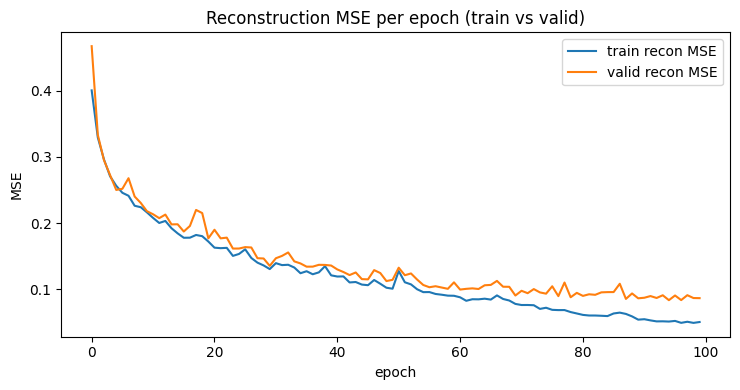

In [4]:
# ==== 시퀀스 생성 함수(동일) ====
WIN  = 128
STEP = 1

def make_seq2one_single_file(X2d, win=WIN, step=STEP):
    N, p = X2d.shape
    Xs, Ys = [], []
    last = N - win
    for s in range(0, last, step):
        Xs.append(X2d[s:s+win])
        Ys.append(X2d[s+win])
    if not Xs:
        return np.empty((0, win, p)), np.empty((0, p))
    return np.stack(Xs), np.stack(Ys)

# ==== 학습: new[0], new[1] / 검증: new[2] ====
X_tr_list, y_tr_list = [], []
for i in [0, 1]:
    X_i, y_i = make_seq2one_single_file(new[i][keep_cols].values, WIN, STEP)
    if len(X_i):
        X_tr_list.append(X_i); y_tr_list.append(y_i)

X_train = np.vstack(X_tr_list) if X_tr_list else np.empty((0, WIN, len(keep_cols)))
y_train = np.vstack(y_tr_list) if y_tr_list else np.empty((0, len(keep_cols)))

X_val, y_val = make_seq2one_single_file(new[2][keep_cols].values, WIN, STEP)

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_val.shape,   y_val.shape)

# ==== 모델 ====
import keras
from keras import layers, models, optimizers, callbacks
import numpy as np
import matplotlib.pyplot as plt

p = X_train.shape[2]
EPOCHS = 100   # ← 100으로 증가
BATCH  = 256

def build_lstm_forecaster(win_len, n_feat):
    inp = layers.Input(shape=(win_len, n_feat))
    x   = layers.LSTM(128, return_sequences=True)(inp)
    x   = layers.LSTM(64,  return_sequences=False)(x)
    x   = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(n_feat, activation=None)(x)  # 다음 스텝 예측(회귀)
    model = models.Model(inp, out, name="LSTM_Forecaster")
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
    return model

fcast = build_lstm_forecaster(WIN, p)
fcast.summary()

# ==== 재구성 오차 함수 ====
def pred_errors(model, X, y, metric="mse"):
    yhat = model.predict(X, verbose=0)
    resid = y - yhat
    if metric == "mse":
        e = np.mean(resid**2, axis=1)
    elif metric == "mae":
        e = np.mean(np.abs(resid), axis=1)
    else:
        raise ValueError("metric should be 'mse' or 'mae'")
    return e, yhat

# ==== 에폭별 Train/Valid MSE 기록 콜백 ====
class TrainValidReconMSE(keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val, train_monitor_n=5000):
        super().__init__()
        n = len(X_train)
        if (train_monitor_n is not None) and (n > train_monitor_n):
            idx = np.linspace(0, n-1, train_monitor_n, dtype=int)
            self.X_trm = X_train[idx]; self.y_trm = y_train[idx]
        else:
            self.X_trm = X_train; self.y_trm = y_train
        self.X_val = X_val; self.y_val = y_val
        self.hist_tr = []; self.hist_va = []

    def on_epoch_end(self, epoch, logs=None):
        e_tr, _ = pred_errors(self.model, self.X_trm, self.y_trm, "mse")
        e_va, _ = pred_errors(self.model, self.X_val, self.y_val, "mse")
        tr_mean = float(np.mean(e_tr)); va_mean = float(np.mean(e_va))
        self.hist_tr.append(tr_mean); self.hist_va.append(va_mean)
        print(f"[Epoch {epoch+1:03d}] recon MSE - train(mean)={tr_mean:.6f} | valid(mean)={va_mean:.6f}")

cb_tv = TrainValidReconMSE(X_train, y_train, X_val, y_val, train_monitor_n=5000)

# ==== EarlyStopping 추가 ====
cb_es = callbacks.EarlyStopping(
    monitor="val_loss",      # 검증 MSE 모니터
    patience=10,             # 10 에폭 개선 없으면 중단
    mode="min",
    restore_best_weights=True
)

# (선택) 베스트 모델 저장까지 원하면 체크포인트도 추가 가능
# cb_ckpt = callbacks.ModelCheckpoint(
#     "artifacts/fcast_best.keras",
#     monitor="val_loss", mode="min",
#     save_best_only=True
# )

history = fcast.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    shuffle=False,
    callbacks=[cb_tv, cb_es],  # 필요시 cb_ckpt 추가
    verbose=1
)

# ==== 에폭별 재구성 오차 곡선 ====
plt.figure(figsize=(7.5,4))
plt.plot(cb_tv.hist_tr, label="train recon MSE")
plt.plot(cb_tv.hist_va, label="valid recon MSE")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.title("Reconstruction MSE per epoch (train vs valid)")
plt.legend(); plt.tight_layout(); plt.show()


In [6]:
WIN  = 128   # 창 길이(32~256 탐색 권장)
STEP = 1     # 다음 스텝 예측이므로 보통 1
def make_seq2one_single_file(X2d, win=WIN, step=STEP):
    """
    X2d: (N,p) 한 파일의 시계열
    반환: X:(n_win, win, p), y:(n_win, p)  # y는 다음 시점 벡터
    """
    N, p = X2d.shape
    Xs, Ys = [], []
    last = N - win - 0   # y는 win 직후 시점
    for s in range(0, last, step):
        Xs.append(X2d[s:s+win])
        Ys.append(X2d[s+win])   # 다음 1스텝
    if not Xs:
        return np.empty((0, win, p)), np.empty((0, p))
    return np.stack(Xs), np.stack(Ys)

# === 학습/평가 세트 생성 ===
X_train_list, y_train_list = [], []
for i in range(3):
    X_i, y_i = make_seq2one_single_file(new[i][keep_cols].values, WIN, STEP)
    if len(X_i): 
        X_train_list.append(X_i); y_train_list.append(y_i)
X_train = np.vstack(X_train_list); y_train = np.vstack(y_train_list)

X_worn = []; y_worn = []
for i in range(3):
    X_i, y_i = make_seq2one_single_file(worn[i][keep_cols].values, WIN, STEP)
    X_worn.append(X_i); y_worn.append(y_i)

X_new_eval = []; y_new_eval = []
for i in range(3):
    X_i, y_i = make_seq2one_single_file(new[i][keep_cols].values, WIN, STEP)
    X_new_eval.append(X_i); y_new_eval.append(y_i)

X_train.shape, y_train.shape


((5760, 128, 5), (5760, 5))

In [7]:
# import keras
# from keras import layers, models, optimizers

# p = X_train.shape[2]
# EPOCHS = 40
# BATCH  = 256

# def build_lstm_forecaster(win_len, n_feat):
#     inp = layers.Input(shape=(win_len, n_feat))
#     x   = layers.LSTM(128, return_sequences=True)(inp)
#     x   = layers.LSTM(64,  return_sequences=False)(x)
#     x   = layers.Dense(64, activation="relu")(x)
#     out = layers.Dense(n_feat, activation=None)(x)  # 다음 스텝 벡터
#     model = models.Model(inp, out, name="LSTM_Forecaster")
#     model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
#     return model

# fcast = build_lstm_forecaster(WIN, p)
# fcast.summary()

# history = fcast.fit(
#     X_train, y_train,
#     epochs=EPOCHS, batch_size=BATCH,
#     shuffle=False,    # 순서 유지
#     verbose=1
# )


Model: "LSTM_Forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 5)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128, 128)            │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - loss: 0.5865
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - loss: 0.3114
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - loss: 0.2633
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - loss: 0.2494
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - loss: 0.2356
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - loss: 0.2282
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 332ms/step - loss: 0.2135
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - loss: 0.2060
Epoch 9/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - loss: 0.1979
Epoch 10/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - loss: 0.1950
Epoch 11/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - loss: 0.1836
Epoch 12/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - loss: 0.2019
Epoch 13/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - loss: 0.1843
Epoch 14/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - loss: 0.1754
Epoch 15/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - l

In [7]:
import numpy as np
from sklearn.metrics import roc_auc_score

def pred_errors(model, X, y, metric="mse"):
    yhat = model.predict(X, verbose=0)      # (n_win, p)
    resid = y - yhat
    if metric == "mse":
        e = np.mean(resid**2, axis=1)       # 표본별 스칼라
    elif metric == "mae":
        e = np.mean(np.abs(resid), axis=1)
    else:
        raise ValueError("metric should be 'mse' or 'mae'")
    return e, yhat

err_tr, _ = pred_errors(fcast, X_train, y_train, metric="mse")
thr = np.percentile(err_tr, 95)  # 상위 5% 임계값(운영 목적에 맞게 97~99도 시도)
print(f"Train pred MSE mean={err_tr.mean():.6f}, p95={thr:.6f}, p99={np.percentile(err_tr,99):.6f}")

def eval_block(name, X, y):
    if len(X)==0:
        print(f"{name}: 윈도우 부족")
        return None
    e, _ = pred_errors(fcast, X, y)
    ratio = (e > thr).mean()
    print(f"{name}: n={len(X)}, 이상비율={ratio:.3f}, err mean={e.mean():.6f}, p95={np.percentile(e,95):.6f}")
    return e

print("\n— WORN —")
err_w = [eval_block(f"worn[{i}]", X_worn[i], y_worn[i]) for i in range(3)]
print("\n— NEW  —")
err_n = [eval_block(f"new[{i}]",  X_new_eval[i], y_new_eval[i]) for i in range(3)]

# ROC-AUC (new=0, worn=1; 오차는 높을수록 이상)
if all(v is not None for v in err_w+err_n):
    y_true  = np.concatenate([np.zeros_like(e) for e in err_n] + [np.ones_like(e) for e in err_w])
    y_score = np.concatenate(err_n + err_w)
    auc = roc_auc_score(y_true, y_score)
    print(f"\nROC-AUC (LSTM Forecast): {auc:.3f}")


Train pred MSE mean=0.061950, p95=0.221607, p99=0.466960

— WORN —
worn[0]: n=1920, 이상비율=0.120, err mean=0.328032, p95=0.555186
worn[1]: n=1920, 이상비율=0.112, err mean=0.296663, p95=0.589906
worn[2]: n=1920, 이상비율=0.099, err mean=0.313694, p95=0.646289

— NEW  —
new[0]: n=1920, 이상비율=0.034, err mean=0.050136, p95=0.168820
new[1]: n=1920, 이상비율=0.039, err mean=0.052226, p95=0.194916
new[2]: n=1920, 이상비율=0.077, err mean=0.083489, p95=0.281384

ROC-AUC (LSTM Forecast): 0.540


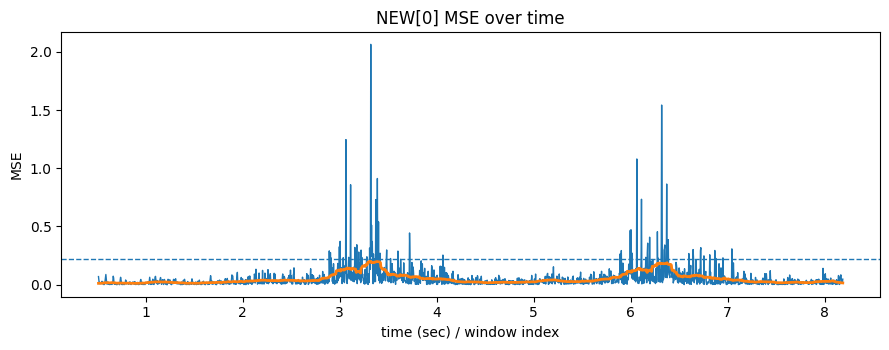

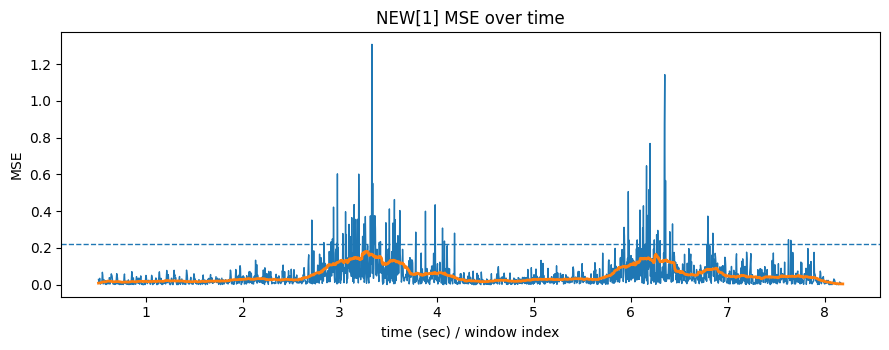

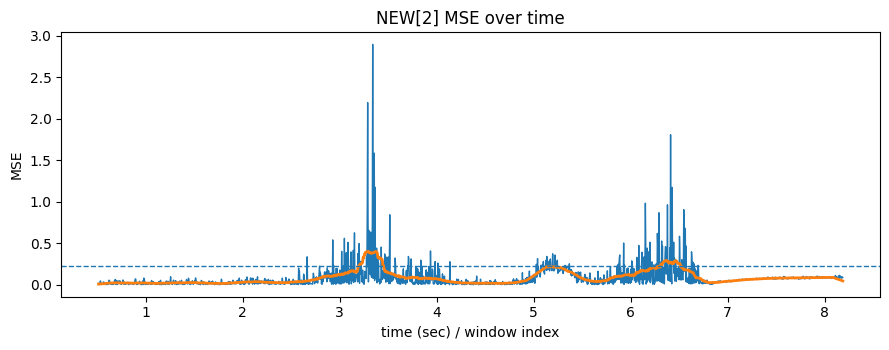

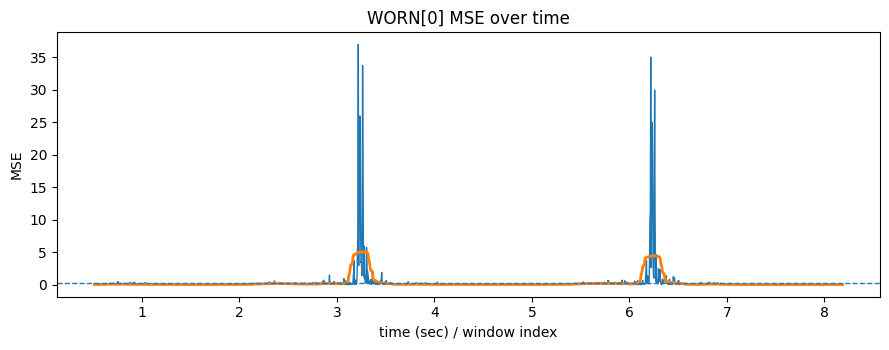

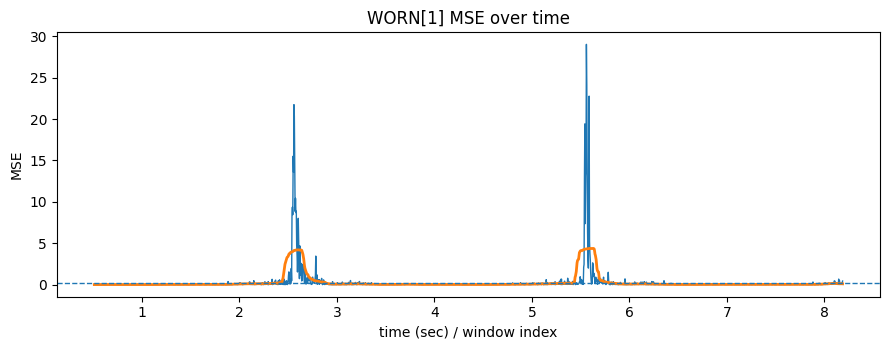

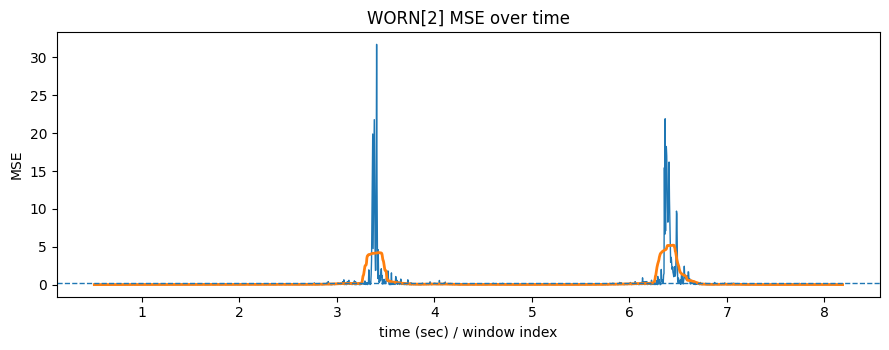

In [8]:
# ==== LSTM 예측오차 라인그래프 (파일별) ====
import matplotlib.pyplot as plt

def mse_series(df, model=fcast, win=WIN, step=STEP):
    X2d = df[keep_cols].values
    N, p = X2d.shape
    Xs, Ys, idx = [], [], []
    last = N - win
    for s in range(0, last, step):
        Xs.append(X2d[s:s+win]); Ys.append(X2d[s+win]); idx.append(s+win)
    if not Xs:
        return np.array([]), np.array([])

    Xs = np.stack(Xs); Ys = np.stack(Ys); idx = np.array(idx)
    e, _ = pred_errors(model, Xs, Ys, metric="mse")   # ← 재사용
    if "timestamp" in df.columns:
        ts = df["timestamp"].to_numpy()
        x = ts[idx] - ts[0]
    else:
        x = np.arange(len(e))
    return x, e

def plot_mse_line(x, mse, title="", thr=None, smooth_k=51):
    """단일 플롯: 원시 MSE + (선택) 이동평균 스무딩 + 임계선"""
    plt.figure(figsize=(9,3.6))
    plt.plot(x, mse, linewidth=1)  # 원시
    # 선택: 간단 스무딩(이동평균)
    if smooth_k and len(mse) >= smooth_k:
        k = smooth_k
        kernel = np.ones(k)/k
        mse_s = np.convolve(mse, kernel, mode="same")
        plt.plot(x, mse_s, linewidth=2)  # 스무딩
    if thr is not None:
        plt.axhline(thr, linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("time (sec) / window index"); plt.ylabel("MSE")
    plt.tight_layout(); plt.show()


# NEW/WORN 각각 라인그래프
for tag, dfs in [("NEW", new), ("WORN", worn)]:
    for i, df in enumerate(dfs):
        x, e = mse_series(df)
        if len(e)==0: 
            print(f"{tag}[{i}] 윈도우 부족");
            continue
        plot_mse_line(x, e, title=f"{tag}[{i}] MSE over time", thr=thr, smooth_k=51)


In [9]:
# ==== LSTM 예측 오차로 파일별 점수 시계열 만들기 ====
USE_LOG = False   # 먼저 생(raw) MSE로; 필요하면 True로 바꿔 log1p 사용

def df_to_seq2one(df, win=WIN, step=STEP):
    X2d = df[keep_cols].values
    N, p = X2d.shape
    Xs, Ys, idx = [], [], []
    last = N - win
    for s in range(0, last, step):
        Xs.append(X2d[s:s+win])
        Ys.append(X2d[s+win])
        idx.append(s+win)
    if not Xs:
        return np.empty((0, win, p)), np.empty((0, p)), np.array([])
    return np.stack(Xs), np.stack(Ys), np.array(idx)

def file_score_series_LSTM(df):
    # (윈도우 끝 시점 timestamp, LSTM 예측 MSE 점수)
    X, y, idx = df_to_seq2one(df, win=WIN, step=STEP)
    if len(idx) == 0:
        return np.array([]), np.array([])
    e, _ = pred_errors(fcast, X, y, metric="mse")     # ← 반드시 LSTM 예측 오차!
    s = np.log1p(e) if USE_LOG else e
    ts = df["timestamp"].to_numpy() if "timestamp" in df.columns else np.arange(len(df))
    return ts[idx], s


In [10]:
# ==== NEW 참조 분포(ECDF 기준) ====
scores_new_ref = []
for i in range(3):
    _, s_i = file_score_series_LSTM(new[i])
    if len(s_i):
        scores_new_ref.append(s_i)
scores_new_ref = np.concatenate(scores_new_ref) if scores_new_ref else np.array([0.0])

print("[REF] NEW score stats:",
      "mean=", np.mean(scores_new_ref),
      "p90=", np.percentile(scores_new_ref, 90),
      "p95=", np.percentile(scores_new_ref, 95),
      "p99=", np.percentile(scores_new_ref, 99))


[REF] NEW score stats: mean= 0.06195040440977624 p90= 0.14071207477463835 p95= 0.22160680348562095 p99= 0.46695958524787384


In [11]:
# --- 1) 캘리브레이션용 통계 (이미 계산했으면 재사용 가능) ---
AGG_P = 95; LAST_SECONDS = None

# === ECDF 생성 ===
def build_ecdf_smooth(x, alpha=0.5, beta=0.5):
    xs = np.sort(np.asarray(x)); n = xs.size
    def F(val):
        r = np.searchsorted(xs, val, side="right")
        return (r + alpha) / (n + alpha + beta)
    return F

# NEW 데이터 참조 분포 만들기
scores_new_ref = []
for i in range(3):
    _, s_i = file_score_series_LSTM(new[i])
    if len(s_i):
        scores_new_ref.append(s_i)
scores_new_ref = np.concatenate(scores_new_ref) if scores_new_ref else np.array([0.0])

# ECDF 함수 객체 생성
F_new = build_ecdf_smooth(scores_new_ref, alpha=0.5, beta=0.5)



def agg_and_p_for_files(dfs, agg_p=95, last_seconds=None):
    aggs, ps = [], []
    for df in dfs:
        ts, s = file_score_series_LSTM(df)
        if len(s)==0: continue
        if (last_seconds is None) or ((ts[-1]-ts[0]) < float(last_seconds)):
            agg = np.percentile(s, agg_p)
        else:
            m = ts >= (ts[-1]-last_seconds)
            if m.sum()==0: m[:] = True
            agg = np.percentile(s[m], agg_p)
        p = float(F_new(agg))
        aggs.append(agg); ps.append(p)
    return np.array(aggs), np.array(ps)

aggs_new, p_new = agg_and_p_for_files(new,  agg_p=AGG_P, last_seconds=LAST_SECONDS)
aggs_wrn, p_wrn = agg_and_p_for_files(worn, agg_p=AGG_P, last_seconds=LAST_SECONDS)

p0       = float(np.median(p_new))     # 새 중앙 분위
p_w_med  = float(np.median(p_wrn))     # 마모 중앙 분위
print(f"[calib] p0={p0:.4f}, p_w_med={p_w_med:.4f}")


[calib] p0=0.9371, p_w_med=0.9931


In [12]:
# --- 2) 원하는 기준 설정 ---
H_MAX, H_MIN = 95.0, 5.0     # 상한/하한(원하면 H_MIN=0도 가능)
H_new = 95.0                 # 새 중앙의 목표 Health(%)
H_wrn = 15.0                 # 마모 중앙의 목표 Health(%)
TAU   = 0.007                 # p0 주변 부드러움(0.01~0.02 추천)

# p0에서의 목표 p_shift(작을수록 Health↑). 예: 새 중앙 90%가 되려면:
s0 = 1.0 - ((H_new - H_MIN) / (H_MAX - H_MIN))  # p_shift(p0) = s0
# 시그모이드 바이어스(b) 계산 (logit)
import numpy as np
def logit(u): return np.log(u/(1-u))

b = logit(np.clip(s0, 1e-6, 1-1e-6))            # p=p0일 때 p_shift=s0 되도록
# 마모 중앙에서의 p_shift
s_w = 1.0 / (1.0 + np.exp(-( (p_w_med - p0)/max(1e-9,TAU) + b )))
# gamma는 (1 - s_w)^gamma 가 (H_wrn 정규화값)에 맞도록 결정
target = (H_wrn - H_MIN) / (H_MAX - H_MIN)
gamma  = np.log(np.clip(target,1e-6,1-1e-6)) / np.log(np.clip(1.0 - s_w,1e-9,1.0))
print(f"[calib] s0={s0:.3f}, b={b:.3f}, s_w={s_w:.3f}, gamma={gamma:.3f}")


[calib] s0=0.000, b=-13.816, s_w=0.003, gamma=731.199


In [13]:
# --- 3) 최종 매핑 함수 (soft, 바이어스 포함) ---
def health_ecdf_soft_calib(
        df, agg_p=AGG_P, last_seconds=LAST_SECONDS,
        p0=p0, tau=TAU, b=b, gamma=gamma,
        H_MAX=H_MAX, H_MIN=H_MIN):
    ts, s = file_score_series_LSTM(df)
    if len(s)==0:
        return dict(health=np.nan, agg=np.nan, p=np.nan, p_shift=np.nan)
    if (last_seconds is None) or ((ts[-1]-ts[0]) < float(last_seconds)):
        agg = np.percentile(s, agg_p)
    else:
        m = ts >= (ts[-1]-last_seconds);  agg = np.percentile(s[m], agg_p)

    p = float(F_new(agg))  # NEW ECDF 분위
    # 바이어스된 시그모이드: p=p0 → p_shift=s0
    z = (p - p0)/max(1e-9, tau) + b
    p_shift = 1.0/(1.0 + np.exp(-z))          # 0~1
    health  = H_MIN + (H_MAX - H_MIN) * ((1.0 - p_shift) ** gamma)
    return dict(health=float(np.clip(health,H_MIN,H_MAX)),
                agg=float(agg), p=p, p_shift=float(p_shift))


In [14]:
# --- 4) 실행 & 확인 ---
rows=[]
for tag, dfs in [("new", new), ("worn", worn)]:
    for i, df in enumerate(dfs):
        r = health_ecdf_soft_calib(df)
        rows.append(dict(group=tag, file=i, health=r["health"], agg=r["agg"], p=r["p"], p_shift=r["p_shift"]))
import pandas as pd
pd.DataFrame(rows).sort_values(["group","file"])


,group,file,health,agg,p,p_shift
0,new,0,94.994062,0.168820,0.920240,9.023522e-08
1,new,1,94.934216,0.194916,0.937077,1.000000e-06
2,new,2,89.331644,0.281384,0.968495,8.896296e-05
3,worn,0,16.703516,0.555186,0.992623,2.785942e-03
4,worn,1,15.000000,0.589906,0.993144,3.000452e-03
5,worn,2,12.033720,0.646289,0.994185,3.480115e-03


In [15]:
# 1) Keras LSTM 모델 저장 (Keras 3)
fcast.save("artifacts/fcast.keras")
import joblib
from sklearn.preprocessing import StandardScaler

# fit 이후
scaler = StandardScaler()
scaler.fit(X_new_all)

# 저장
joblib.dump(scaler, "artifacts/scaler.pkl")

# 불러오기
scaler_loaded = joblib.load("artifacts/scaler.pkl")

# 확인 (mean_, scale_ 같은 속성 유지됨)
print(scaler_loaded.mean_, scaler_loaded.scale_)
import json

# StandardScaler에서 필요한 값 추출
scaler_art = {
    "mean":  scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist(),
    "keep_cols": keep_cols,   # 어떤 컬럼을 사용했는지
    "WIN": int(WIN),          # LSTM 윈도우 길이
    "STEP": int(STEP)         # 시퀀스 스텝
}

# JSON 파일로 저장
with open("artifacts/scaler_config.json", "w", encoding="utf-8") as f:
    json.dump(scaler_art, f, ensure_ascii=False, indent=2)

print("✅ scaler_config.json 저장 완료")
fcast.save("artifacts/fcast.h5")

[-1.21192348e-01  4.47923547e-05  8.37616981e+02  1.24119061e+03
  6.19799585e-01] [3.66233383e-01 3.88679708e-02 1.25583807e+03 6.88612054e+02
 1.30899594e-01]
✅ scaler_config.json 저장 완료


In [17]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [10]:
import tensorflow as tf, sys
print("TF:", tf.__version__)
print("tf.keras:", tf.keras.__version__)
# 별도 keras(=Keras 3)가 깔려 있다면
import keras, importlib
print("keras(pkg):", keras.__version__)
print("keras path:", importlib.import_module("keras").__file__)


TF: 2.20.0
tf.keras: 3.10.0
keras(pkg): 3.10.0
keras path: C:\Users\human\anaconda3\envs\abc\lib\site-packages\keras\__init__.py
